# Code exploration
* [1. Import Libraries & Data](#1.ImportLibraries&Data)
* [2. Explore Data](#2.ExploreData)
* [3. Add Features](#3.AddFeatures)
* [4. Chi Square Tests](#4.ChiSquareTests)
* [5. Data Visualization](#5.DataVisualization)

## 1. Import Libraries & Data <a class="anchor" id="1.ImportLibraries&Data"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from datetime import timedelta
from datetime import date
from scipy.stats import chisquare
import seaborn as sns
plt.rcParams.update({'font.size': 15})
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment',None)

In [2]:
df_users=pd.read_csv('takehome_users.csv')
df_user_engagement=pd.read_csv('takehome_user_engagement.csv')

## 2. Explore Data <a class="anchor" id="2.ExploreData"></a>

In [3]:
#Convert time strings to datetime objects
df_users.last_session_creation_time=pd.to_datetime(df_users.last_session_creation_time, unit='s')
df_users.creation_time=pd.to_datetime(df_users.creation_time)
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [4]:
#Convert time strings to datetime objects
df_user_engagement.time_stamp=pd.to_datetime(df_user_engagement.time_stamp)
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


Do the number of unique users in user engagement match the user engagement data?

In [5]:
len(df_user_engagement.user_id.unique()), len(df_users.object_id.unique())

(8823, 12000)

No, they don't. Which means the engagement data for about 4,000 users (33% of the data set) are missing - this data will have to be dropped, since its unclear whether they adopted the platform or not.

## 3. Add Features <a class="anchor" id="3.AddFeatures"></a>

### Determine if a user adopted the platform or not

In [6]:
#Make a function to define if a user adopted the platform or not
def adopted_user(x):
    day_7=pd.Timedelta("7 days")
    count=[(x.iloc[i+2]-x.iloc[i])<day_7 for i in range(len(x)-2)]
    if sum(count)>0:
        return 1
    else:
        return 0
    
#Use the function above to determine if users in engagement data were active or not, return a new dataframe
user_adoption=pd.DataFrame(df_user_engagement.groupby('user_id').agg(adopted_user))
user_adoption=user_adoption.reset_index().rename(columns={0:'user_id','time_stamp':'adopted'})
user_adoption.head()

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [7]:
#Merge the user id & adoption dataframe into the original users dataframe
df_users=df_users.merge(user_adoption,how='left',left_on='object_id',right_on='user_id').drop(columns='user_id')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


### Determine overall adoption rate

In [8]:
var="adopted"
no=df_users[var].value_counts()[0]
yes=df_users[var].value_counts()[1]
prevalence=(yes/(no+yes))
pct=round(prevalence*100,2)
print("{} users adopted the platform, {} didn't, for a rate of {}%".format(yes, no,pct))

1602 users adopted the platform, 7221 didn't, for a rate of 18.16%


### Preprocess the emails - keep only the domain names

In [9]:
#Only keep the domains of all the emails
df_users.email=df_users.email.agg(lambda x: [val[1] for val in x.str.split('@')])
#Write function to cast uncommon emails as 'other'
def reduce_email(x):
    email_list=df_users['email'].value_counts()[0:6]
    return [email if email in email_list else 'other' for email in x]
#Apply function to email column
df_users.email=reduce_email(list(df_users.email.values))

### Indicate if a user invited someone else

In [10]:
#Fill any missing 'invited_by_user_id' with 0, indicating that no one invited them 
df_users.invited_by_user_id.fillna(value=0,inplace=True)
#Make the org_id, invited by user, object id column a string
for col in df_users.columns:
    if df_users[col].dtype=='int64' or df_users[col].dtype=='float64':
        df_users[col]=df_users[col].astype(object)

In [11]:
#Add column 'invited_other_user' to indicate if a user invited someone else
df_users_invite=df_users[['invited_by_user_id']]
df_users_invite.invited_by_user_id=df_users_invite.invited_by_user_id.astype('str')
df_users_invite.rename(columns={'invited_by_user_id':'inviter_id'},inplace=True)
df_users_invite['invited_other_user']=1
df_users_invite.drop_duplicates(inplace=True)
df_users=df_users.merge(df_users_invite,how='left',left_on='object_id',right_on='inviter_id')
df_users.drop(columns='inviter_id',inplace=True)
df_users.invited_other_user=df_users.invited_other_user.fillna(value=0)

In [12]:
#Drop any rows with missing values
df_users=df_users.dropna(axis=0,how='any')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   object        
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   object        
 7   enabled_for_marketing_drip  8823 non-null   object        
 8   org_id                      8823 non-null   object        
 9   invited_by_user_id          8823 non-null   object        
 10  adopted                     8823 non-null   object        
 11  invited_other_user          8823 non-null   float64    

## 4. Chi Square Tests <a class="anchor" id="4.ChiSquareTests"></a>

In [13]:
#Calculate the percent of users adopted for each variable within a feature. This will only be used on features that 
#have just a handful of variable groups (i.e. not org_id or  invited_by_user_id)
def pct(var):
    df_test=pd.DataFrame(df_users.groupby([var,'adopted']).size().rename('obs_count')).reset_index()
    df_test['group_total']=df_test.groupby(var)['obs_count'].transform(sum)
    df_test['obs_freq']=df_test.groupby(var)['obs_count'].transform(lambda x: [x.iloc[0]/sum(x),x.iloc[1]/sum(x)])
    df_test['exp_freq']=df_test.groupby(var)['obs_count'].transform(lambda x: [1-prevalence,prevalence])
    df_test['exp_count']=df_test.groupby(var)['obs_count'].transform(lambda x: [round(sum(x)*(1-prevalence)),round(sum(x)*prevalence)])
    df_test=df_test[[var, 'adopted','group_total','obs_freq', 'exp_freq', 'obs_count', 'exp_count']]
    return df_test

In [14]:
#Create an empty dictionary for storing stats
stats={}

In [15]:
#Calculate chi square for invited other user, print statistics
var='invited_other_user'
df_invite=pct(var)
a,b=chisquare(f_obs=df_invite.obs_count,f_exp=df_invite.exp_count)
stats[var]=b
print("Chi Stat: {}, pvalue: {}".format(a,b))
df_invite.sort_values(by=var)

Chi Stat: 0.0, pvalue: 1.0


,invited_other_user,adopted,group_total,obs_freq,exp_freq,obs_count,exp_count
0,0.0,0.0,8823,0.818429,0.818429,7221,7221
1,0.0,1.0,8823,0.181571,0.181571,1602,1602


In [16]:
#Calculate chi square for opted into mailing list, print statistics
var='opted_in_to_mailing_list'
df_ml=pct(var)
a,b=chisquare(f_obs=df_ml.obs_count,f_exp=df_ml.exp_count)
stats[var]=b
print("Chi Stat: {}, pvalue: {}".format(a,b))
df_ml.sort_values(by=var)

Chi Stat: 0.4044038971160933, pvalue: 0.9393312577649852


,opted_in_to_mailing_list,adopted,group_total,obs_freq,exp_freq,obs_count,exp_count
0,0,0.0,6597,0.819918,0.818429,5409,5399
1,0,1.0,6597,0.180082,0.181571,1188,1198
2,1,0.0,2226,0.814016,0.818429,1812,1822
3,1,1.0,2226,0.185984,0.181571,414,404


In [17]:
#Calculate chi square for marketing drip, print statistics
var='enabled_for_marketing_drip'
df_md=pct(var)
a,b=chisquare(f_obs=df_md.obs_count,f_exp=df_md.exp_count)
stats[var]=b
print("Chi Stat: {}, pvalue: {}".format(a,b))
df_md.sort_values(by=var)

Chi Stat: 0.05332614261670977, pvalue: 0.9967767656651135


,enabled_for_marketing_drip,adopted,group_total,obs_freq,exp_freq,obs_count,exp_count
0,0,0.0,7482,0.818765,0.818429,6126,6123
1,0,1.0,7482,0.181235,0.181571,1356,1359
2,1,0.0,1341,0.816555,0.818429,1095,1098
3,1,1.0,1341,0.183445,0.181571,246,243


In [18]:
#Calculate chi square for creation source, print statistics
var='creation_source'
df_cs=pct(var)
a,b=chisquare(f_obs=df_cs.obs_count,f_exp=df_cs.exp_count)
stats[var]=b
print("Chi Stat: {}, pvalue: {}".format(a,b))
df_cs.sort_values(by='creation_source')

Chi Stat: 40.24614500630668, pvalue: 6.856597952617988e-06


,creation_source,adopted,group_total,obs_freq,exp_freq,obs_count,exp_count
0,GUEST_INVITE,0.0,1588,0.773300,0.818429,1228,1300
1,GUEST_INVITE,1.0,1588,0.226700,0.181571,360,288
2,ORG_INVITE,0.0,3188,0.826537,0.818429,2635,2609
3,ORG_INVITE,1.0,3188,0.173463,0.181571,553,579
4,PERSONAL_PROJECTS,0.0,764,0.785340,0.818429,600,625
5,PERSONAL_PROJECTS,1.0,764,0.214660,0.181571,164,139
6,SIGNUP,0.0,1898,0.845627,0.818429,1605,1553
7,SIGNUP,1.0,1898,0.154373,0.181571,293,345
8,SIGNUP_GOOGLE_AUTH,0.0,1385,0.832491,0.818429,1153,1134
9,SIGNUP_GOOGLE_AUTH,1.0,1385,0.167509,0.181571,232,251


In [19]:
#Calculate chi square for email, print statistics
var='email'
df_em=pct(var)
a,b=chisquare(f_obs=df_em.obs_count,f_exp=df_em.exp_count)
stats[var]=b
print("Chi Stat: {}, pvalue: {}".format(a,b))
df_em.sort_values(by=var)

Chi Stat: 35.47520612897503, pvalue: 0.0007153902423480736


,email,adopted,group_total,obs_freq,exp_freq,obs_count,exp_count
0,cuvox.de,0.0,828,0.833333,0.818429,690,678
1,cuvox.de,1.0,828,0.166667,0.181571,138,150
2,gmail.com,0.0,2930,0.814676,0.818429,2387,2398
3,gmail.com,1.0,2930,0.185324,0.181571,543,532
4,gustr.com,0.0,842,0.830166,0.818429,699,689
5,gustr.com,1.0,842,0.169834,0.181571,143,153
6,hotmail.com,0.0,803,0.754670,0.818429,606,657
7,hotmail.com,1.0,803,0.245330,0.181571,197,146
8,jourrapide.com,0.0,883,0.815402,0.818429,720,723
9,jourrapide.com,1.0,883,0.184598,0.181571,163,160


In [20]:
#Print p-values for each variable tested so far
stats

{'invited_other_user': 1.0,
 'opted_in_to_mailing_list': 0.9393312577649852,
 'enabled_for_marketing_drip': 0.9967767656651135,
 'creation_source': 6.856597952617988e-06,
 'email': 0.0007153902423480736}

## 5. Data Visualization <a class="anchor" id="5.DataVisualization"></a>

### Exploring Invitation Group Size

In [21]:
def pct_incomplete(var):
    df_test=pd.DataFrame(df_users.groupby([var,'adopted']).size().rename('obs_count')).reset_index()
    df_test['group_total']=df_test.groupby(var)['obs_count'].transform(sum)
    df_test['obs_prevalence']=round(df_test['obs_count']/df_test['group_total'],3)
    df_test.drop_duplicates(subset=[var],keep='last',inplace=True)
    df_test.loc[df_test.adopted==0,'obs_prevalence']=0
    df_test.loc[df_test.adopted==0,'obs_count']=0
    df_test.drop(columns='adopted',inplace=True)
    df_test=df_test.sort_values(by='obs_prevalence',ascending=False)
    return df_test

In [22]:
#Define invite group size stratifications
def invite_size(x):
    if x>1000:
        return 'Not Invited'
    if x>=5:
        return '5-10 Invites'
    else:
        return '1-4 Invites'

In [23]:
var='invited_by_user_id'
df_invite=pct_incomplete(var)
df_invite.sort_values(by='group_total',ascending=False).head(10)

,invited_by_user_id,obs_count,group_total,obs_prevalence
1,0.0,689,4047,0.170
1066,4612.0,2,10,0.200
520,2308.0,1,9,0.111
2693,11770.0,1,9,0.111
1566,6808.0,0,8,0.000
157,730.0,3,8,0.375
1113,4803.0,2,8,0.250
527,2354.0,4,8,0.500
326,1525.0,0,8,0.000
732,3261.0,1,8,0.125


In [24]:
def org_pct(x):
    group_=sum(x['group_total'])
    adopted_=sum(x['obs_count'])
    return adopted_/group_

In [25]:
df_invite['group_size']=df_invite.group_total.apply(invite_size)
df_invite.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 1292 to 2738
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invited_by_user_id  2230 non-null   float64
 1   obs_count           2230 non-null   int64  
 2   group_total         2230 non-null   int64  
 3   obs_prevalence      2230 non-null   float64
 4   group_size          2230 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 104.5+ KB


In [26]:
df_invite['group_size']=df_invite.group_total.apply(invite_size)
df_invite_=pd.DataFrame(df_invite.groupby('group_size').apply(org_pct)).rename(columns={0:'adoption_prevalence'})
df_size=pd.DataFrame(df_invite.groupby('group_size')['group_total'].apply(sum))
df_invite=pd.concat([df_invite_,df_size],axis=1)
df_invite

,adoption_prevalence,group_total
group_size,,
1-4 Invites,0.193724,3665
5-10 Invites,0.182718,1111
Not Invited,0.170250,4047


### Exploring Organization Size

In [27]:
#Give fake, unique organization numbers to those users that don't belong to any organization 
no_org=list(df_users[df_users.org_id==0].object_id)
fake_org=[df_users.org_id.max()+1+i for i in range(len(no_org))]
for i,j in zip(no_org,fake_org):
    df_users.loc[df_users.object_id==i, 'org_id']=j

In [28]:
#Define organization size stratifications
def orgsize(x):
    if x>=100:
        return '>100 Users'
    elif x>=50:
        return '50-99 Users'
    elif x>= 25:
        return '25-49 Users'
    elif x>= 10:
        return '10-24 Users'
    elif x>1:
        return '2-9 Users'
    else:
        return '1 User (No Org)'

In [29]:
#Calclate the adoption prevalence for each group
def org_pct(x):
    group_=sum(x['group_total'])
    adopted_=sum(x['obs_count'])
    return adopted_/group_

In [30]:
#Calculate statistics
var='org_id'
df_org=pct_incomplete(var)
df_org.sort_values('group_total',ascending=False)
df_org['org_size']=df_org.group_total.apply(orgsize)
df_adoption=pd.DataFrame(df_org.groupby('org_size').apply(org_pct)).rename(columns={0:'adoption'}).sort_values(by='adoption',ascending=False)
df_size=pd.DataFrame(df_org.groupby('org_size').group_total.apply(sum))
df_org_=pd.concat([df_adoption,df_size],axis=1)
df_org_.reset_index(inplace=True)
df_org_

,org_size,adoption,group_total
0,2-9 Users,0.219424,278
1,10-24 Users,0.206882,4708
2,25-49 Users,0.172414,2146
3,50-99 Users,0.146465,792
4,>100 Users,0.104322,671
5,1 User (No Org),0.048246,228


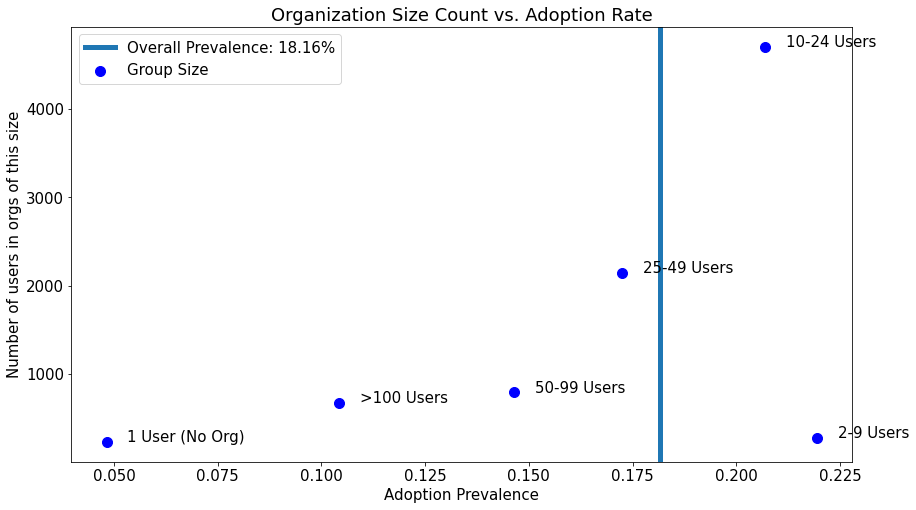

In [31]:
#Plot results
plt.subplots(figsize=(14,8))
plt.scatter(df_org_['adoption'], df_org_['group_total'], marker='o',c='blue',s=100,label='Group Size')
for s, x, y in zip(df_org_['org_size'],df_org_['adoption'], df_org_['group_total']):
    plt.annotate(s, (x+0.005, y))
plt.axvline(prevalence,lw=5,label='Overall Prevalence: {}%'.format(round(prevalence*100,2)))
plt.xlabel('Adoption Prevalence')
plt.ylabel('Number of users in orgs of this size')
plt.title('Organization Size Count vs. Adoption Rate')
plt.legend()
plt.show()